In [94]:
import glob
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt

In [56]:
gages = pd.read_csv('./data/CATCHMENT_v1.csv')

In [57]:
gages.loc[gages.Lat_snap == -9999,'Lat_snap'] = np.NaN
gages.loc[gages.Long_snap == -9999,'Long_snap'] = np.NaN

In [58]:
gages.dropna(inplace=True)

In [60]:
def fixRegion(df):
    reg = df.NHDPlusReg
    
    if reg[:2] == '03':
        reg = '03'
        
    if reg[:2] == '10':
        reg = '10'
    
    return reg

In [61]:
def createFileName(df):
    fn = 'region_%s_gageNo_%s_watershed_NHDplusV2_1.shp'%(df.NHDPlusReg,df.Gage_no)
    return fn

In [62]:
gages.NHDPlusReg = gages.apply(fixRegion, axis = 1)

In [63]:
gages['fileName'] = gages.apply(createFileName, axis = 1)

In [64]:
regions = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18']

In [65]:
compGages = pd.read_csv('./data/completed_gauges.txt',names=['fileName'])

In [66]:
def getRegion(fileName):
    return fileName.split('_')[1]

In [67]:
compGages['Reg'] = compGages.fileName.map(getRegion)

In [68]:
missing = []

for reg in regions:
    allGages = list(gages.loc[gages.NHDPlusReg == reg].fileName.values)
    haveGages = list(compGages.loc[compGages.Reg == reg].fileName.values)
    needGages = list(set(allGages) - set(haveGages)) # compute the needed dates
    print('Region %s: %s Missing. Ratio: %s/%s'%(reg,len(needGages),len(haveGages), len(allGages)))
    missing.append(len(needGages))

Region 01: 0 Missing. Ratio: 408/408
Region 02: 0 Missing. Ratio: 1036/1036
Region 03: 0 Missing. Ratio: 1419/1419
Region 04: 0 Missing. Ratio: 589/589
Region 05: 0 Missing. Ratio: 939/939
Region 06: 0 Missing. Ratio: 330/330
Region 07: 0 Missing. Ratio: 943/943
Region 08: 0 Missing. Ratio: 460/460
Region 09: 0 Missing. Ratio: 173/173
Region 10: 0 Missing. Ratio: 1568/1570
Region 11: 0 Missing. Ratio: 746/746
Region 12: 0 Missing. Ratio: 490/490
Region 13: 0 Missing. Ratio: 281/281
Region 14: 0 Missing. Ratio: 434/434
Region 15: 0 Missing. Ratio: 303/303
Region 16: 0 Missing. Ratio: 321/321
Region 17: 0 Missing. Ratio: 1228/1230
Region 18: 435 Missing. Ratio: 557/993


In [39]:
out = pd.DataFrame()
out['region'] = regions
out['missing'] = missing

In [40]:
out.loc[out.missing == 0]

,region,missing
0,01,0
3,04,0
4,05,0
5,06,0
7,08,0
8,09,0
11,12,0
13,14,0
14,15,0
15,16,0


## Check Delineated Areas against NWIS

In [70]:
gages.head()

,FID,Gage_no,Gage_name,Gage_type,Lat_nwis,Long_nwis,Area_nwis,Lat_snap,Long_snap,COMID,...,State,CHECKED,QC_notes1,REVIEWED,Rev_notes2,Ver_notes3,Gage_info,DropReason,QC_final,fileName
0,0,1098530,"SUDBURY RIVER AT SAXONVILLE, MA",ContGage,42.325373,-71.397560,274.538739,42.325326,-71.397449,6772927,...,MA,,,,,,,,,region_01_gageNo_1098530_watershed_NHDplusV2_1...
1,1,1122680,"MERRICK BK NR SCOTLAND, CT.",CrestStage,41.728988,-72.085076,13.493838,41.728987,-72.084926,6162963,...,CT,,,,,,,,,region_01_gageNo_1122680_watershed_NHDplusV2_1...
2,2,1176000,"QUABOAG RIVER AT WEST BRIMFIELD, MA",ContGage,42.182316,-72.263691,388.498215,42.182412,-72.263445,7690649,...,MA,,,,,,,,,region_01_gageNo_1176000_watershed_NHDplusV2_1...
3,3,1173500,"WARE RIVER AT GIBBS CROSSING, MA",ContGage,42.236204,-72.272580,510.227656,42.236129,-72.272568,7690465,...,MA,,,,,,,,,region_01_gageNo_1173500_watershed_NHDplusV2_1...
4,4,1127500,"YANTIC RIVER AT YANTIC, CT",ContGage,41.558709,-72.121467,231.285937,41.558570,-72.121492,6168318,...,CT,"JAF, 12/21/2015",OK.,"GCB, 3/24/2017","Yes agree with move, location of streamgage is...",,,,OK,region_01_gageNo_1127500_watershed_NHDplusV2_1...


In [73]:
def createPath(gages):
    reg = gages.NHDPlusReg
    gageNo = gages.Gage_no
    
    fl = '/data1/projectsx/WAUSP_National_Model/CPG_data/data/CATCHMENT_watersheds/region_%s_gageNo_%s_watershed_NHDplusV2_1.shp'%(reg,gageNo)
    
    return fl

In [74]:
gages['delinFile'] = gages.apply(createPath,axis=1)

In [82]:
def computeDelinArea(fl):
    dat = gpd.read_file(fl)
    return dat.area_sqkm.sum()

In [119]:
tmp = gages.loc[gages.NHDPlusReg == '01'].copy()

In [120]:
tmp['delinArea'] = tmp.delinFile.map(computeDelinArea)

In [121]:
tmp['delinDiff'] = tmp.Area_nwis - tmp.delinArea

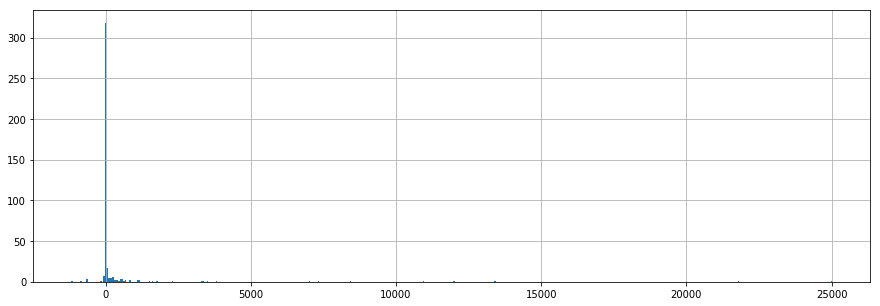

In [122]:
tmp.delinDiff.hist(figsize=(15,5),bins=500)

In [118]:
tmp.loc[tmp.delinDiff < 1].shape

(343, 27)

In [124]:
gages.loc[gages.NHDPlusReg == '02'].Gage_no.max()

143400680